In [1]:
import json
import torch
import re
import numpy as np
import collections

from torch import nn
from torch.optim import SGD, Adam
from google.colab import files, auth, drive
from urllib.request import urlopen
from typing import List, Dict, Callable
from collections import Counter
from os import path
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
drive.mount('/content/gdrive')

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
cuda


In [0]:
'''=================================  HYPERPARAMETERS  ================================='''

_hyperparameters_dict = {
    "batch_size": 32,
    "num_epochs": 1000,
    "max_len": 200,
    "max_sentence_word_length" : 30,
    "embedding_size": 100,
    "rnn_size": 512,
    "learning_algo": "adam",
    "learning_rate": 0.001,
    "output_size" : 4,
    "max_grad_norm": 3.0
}


In [0]:
'''=================================  DEFINES  ================================='''

'''======= Paths ======='''

TrainPath = "gdrive/My Drive/Datasets/Emoji/demojized_train.txt"
TestPath = "gdrive/My Drive/Datasets/Emoji/demojized_dev.txt"


In [4]:
%ls "gdrive/My Drive/Datasets/Emoji/"

demojized_devEmotion.txt    demojized_train_feelings.txt
demojized_dev_feelings.txt  demojized_train.txt
demojized_dev.txt           glove.twitter.27B.100d.txt
demojized_trainEmotion.txt


In [0]:
'''=================================  EXTERNAL FUNCTIONS  ================================='''


def readfile(filepath: str) -> str:
    """
    Reads file and returns its content as a string.
    """
    #response = urlopen(url)
    #body = response.read().decode('utf-8')
    with open(filepath, "r") as f:
        body = f.read()
    
    return body.encode('ascii', 'ignore').decode("utf-8")

  
def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += len(sub) 
  
  
  

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

In [0]:
'''================================= CUSTOM DATA-STRUCTURES  ================================='''
#Mostly pentru label-uri
class TwoWayDict():
  
  def __init__(self,):
    self.to_number = collections.OrderedDict()
    self.to_language = collections.OrderedDict()
    

    
  def insert(self,word):
    if not word in self.to_number:
      new_index = len(self.to_number)
      self.to_number[word] = new_index
      self.to_language[new_index] = word
    
    
  def getindex(self,word):
    return self.to_number[word]
  
  def getlabel(self,label):
    return self.to_language[label]
  
  def getlabellist(self):
    label_list = []
    for label,value in self.to_language.items():
      label_list.append(value)
    
    return label_list
  
class OneVsOthersDict():
  
  def __init__(self,):
      self.to_number = collections.OrderedDict()
      self.to_language = collections.OrderedDict()
    
  def insert(self,word):    
    if word == 'others':
      self.to_number[word] = 0
      self.to_language[0] = word
    else:
      self.to_number[word] = 1
      self.to_language[1] = 'feelings'
        
        
  def printitems(self):
      for label,value in self.to_number.items():
        print(label + ' ' + str(value))
        
  def getindex(self,word):
    return self.to_number[word]
  
  def getlabel(self,label):
    return self.to_language[label]
  
  def getlabellist(self):
    label_list = []
    for label,value in self.to_language.items():
      label_list.append(value)
    
    return label_list

class TwoWayDict():
  
  def __init__(self,):
    self.to_number = collections.OrderedDict()
    self.to_language = collections.OrderedDict()
    

    
  def insert(self,word):
    if not word in self.to_number:
      new_index = len(self.to_number)
      self.to_number[word] = new_index
      self.to_language[new_index] = word
    
    
  def getindex(self,word):
    return self.to_number[word]
  
  def getlabel(self,label):
    return self.to_language[label]
  
  def getlabellist(self):
    label_list = []
    for label,value in self.to_language.items():
      label_list.append(value)
    
    return label_list

 
  
  
class Vocabulary:
    """
    Helper class that maps characters to unique indices and the other way around
    """
    def __init__(self, text: str):
        #special character for padding shorter sequences in a mini-batches
        characters_set = set("©") 
        characters_set.update(text)

        
        self.char_to_idx = {char:idx for (idx, char) 
                            in enumerate(characters_set)}
        
       
        self.idx_to_char = {idx:char for (idx, char) 
                            in enumerate(characters_set)}
   
    def size(self):
        return len(self.char_to_idx)
      
    def __str__(self):
        return str(self.char_to_idx)
  
  
def text_to_tensor(text: str, vocab: Vocabulary) -> torch.LongTensor:
    """
    Convert a string to a Tensor with corresponding character indices
    e.g. "We have" -> [12, 6, 20, 13, 1, 25, 6] 
    """
    
    
    text_indices = [vocab.char_to_idx[c] for c in text]
    
    return torch.tensor(text_indices)  

  
def tensor_to_text(x: torch.LongTensor, vocab: Vocabulary) -> str:
    """
    Convert a Tensor of character indices to its string representation
    e.g. [12, 6, 20, 13, 1, 25, 6] -> "We have"
    """
    return "".join(vocab.idx_to_char[idx.item()] for idx in x) 
  
  
def get_vocabulary(trainPath : str):
    
    text = readfile(trainPath)
    
    vocab = Vocabulary(text)
    
    return vocab

  
class WordVocab:
  
  
    def __init__(self, text: str):
        #special character for padding shorter sequences in a mini-batches
        
        characters_set = {'<unk>':0,'<pad>':1}
 
        cnt = 2
        for word in text:
            if not word in characters_set:
              characters_set[word] = cnt
              cnt +=1

        
        self.char_to_idx = characters_set
       
        self.idx_to_char = {idx:char for (idx, char) 
                            in enumerate(characters_set)}
        
        #or idx in self.idx_to_char:
        #  print(self.idx_to_char[idx])
  
    def size(self):
        return len(self.char_to_idx)
      
    def __str__(self):
        return str(self.char_to_idx)
  
    
    def text_to_tensor(text: str, vocab: Vocabulary) -> torch.LongTensor:
    
      text_indices = [vocab.char_to_idx[c] for c in text]
    
      return torch.tensor(text_indices)  

    
  
def get_wordvocab(dataPath):
    text = readfile(dataPath)
      
    vocab = WordVocab(text.split())
       
      
    return vocab
  

In [7]:
'''=================================   GLOVE EMBEDDING  ================================='''

'''====== Load Glove Model======'''

def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

  
'''====== Get Word Embeddings ======'''

def get_value(word,gloveModel):
  answer = torch.zeros(100,dtype=torch.float64)  
  if word in gloveModel.keys():
    answer = answer + torch.tensor(gloveModel[word],dtype=torch.float64)  
  return answer


def get_tensor_form(phrase,gloveModel):  
  
  phrase_tensor = get_value(phrase[0],gloveModel)
  for i in range(1,len(phrase)):
    phrase_tensor += get_value(phrase[i], gloveModel)

  return phrase_tensor  
  
  
  
'''====== Instantiate Glove Model ======'''
  
  
#glovePath = "gdrive/My Drive/Datasets/Emoji/glove.twitter.27B.100d.txt"
#gloveModel = loadGloveModel(glovePath)

'====== Instantiate Glove Model ======'

In [0]:
def cut_phrase(phrase, max_length):

  
  phrase_bounds = list(find_all(phrase, '<end>'))

  leftsentence = ""
  middlesentence = ""
  rightsentence = ""
        
  for i in range(phrase_bounds[0],phrase_bounds[1]):
    leftsentence = leftsentence + phrase[i]
  
  for i in range(phrase_bounds[1],phrase_bounds[2]):
    middlesentence = middlesentence + phrase[i]

  for i in range(phrase_bounds[2],phrase_bounds[3]):
    rightsentence = rightsentence + phrase[i]

  
  l1 = len(leftsentence)
  l2 = len(middlesentence)
  l3 = len(rightsentence)
  
  '''
  -8 deoarece de la ultima se taie fix <end> si vrem sa adaugam si un spatiu
  de asemenea se modifica cea din mijloc si la stanga si la dreapta
  '''
  
  while(l1+l2+l3 > max_length - 8):
    
    if(l1 >= l2 and l1 >= l3):
      leftsentence = leftsentence[:-1]
      l1 -= 1
    elif(l2 >= l1 and l2 >= l3):
      middlesentence = middlesentence[:-1]
      l2 -= 1
    else:
      rightsentence = rightsentence[:-1]
      l3 -= 1
    
  middlesentence = " " + middlesentence + " "
  rightsentence = rightsentence + " <end>"
  
  #print(leftsentence + middlesentence + rightsentence  )
    
  return leftsentence + middlesentence + rightsentence  


In [0]:
'''=================================   DATA LOADING  ================================='''
def get_data(path : str,  label_dict: TwoWayDict):
  print(path)
  labelcounter = 0
  words = []
  labels = []
  with open(path) as file:
    cnt = 0 
    for line in file:
      if cnt > 0:
        label = line.split()[-1]
        
        labels.append(label)
        
        templine = line.split(' ')[1:-1]
        
        words.append(templine)

        label_dict.insert(label)

      cnt+=1
  
  return [words,labels]
  
  
  
def get_dataset_loader(words, labels, label_dict, vocabulary, word_vocabulary,max_length=95, max_words=50, max_batch_idx=100, shuffle=True):
  
  dataset_length = len(labels)

  traintensor = torch.zeros(dataset_length,max_length + max_words + 3) # Cele 3 hidden state-uri pe care le cautam :)
  labeltensor = torch.zeros(dataset_length,1)
  
  maxwords = 0
  
  padding_tensor = torch.tensor([vocabulary.char_to_idx["©"]])
  
  for i in range(0, dataset_length):

    
    phrase = words[i]

    currentlabel = labels[i]  
    phrase = ' '.join(phrase)
    
    word_phrase = text_to_tensor_word(words[i], word_vocabulary,max_words)
    #print(word_phrase)
    
    
    if(len(phrase) > max_length):
      phrase = cut_phrase(phrase,max_length)
    
    hidden_state_positions = []
    
    
    hidden_state_positions = list(find_all(phrase, '<end>'))
    hidden_state_positions = [x+4 for x in hidden_state_positions]
    hidden_state_positions.pop(0) # delete the first <end>
    
    
    #print(hidden_state_positions)
    
    #print(phrase)

    
    phrase = text_to_tensor(phrase,vocabulary)
    
    while(phrase.size()[0] < max_length):
      phrase = torch.cat((phrase,padding_tensor))
     
    
    currentlabel = label_dict.getindex(currentlabel)


    hidden_state_positions = torch.tensor(hidden_state_positions).type(torch.LongTensor)
    #print(hidden_state_positions)
    
    #print(hidden_state_positions)
    
    phrase = torch.cat((phrase,hidden_state_positions))
    phrase = torch.cat((phrase,word_phrase))
    phrase = phrase.to(device)
    
    #print(phrase.size())
    
    newlabel = torch.zeros(1).to(device).long()
    newlabel[0]=currentlabel
    currentlabel = newlabel

    traintensor[i] = phrase
    labeltensor[i] = currentlabel
    
  
  large_dataset = TensorDataset(torch.tensor(traintensor).to(device), torch.tensor(labeltensor).to(device))
  large_data_loader = DataLoader(large_dataset, batch_size=max_batch_idx, shuffle=True, drop_last=True)
  return large_data_loader

In [0]:
def text_to_tensor_word(x, wordvocab,max_length):
  
  
    list = []
    
    
    
    for word in x:
      #print(x)
      if word in wordvocab.char_to_idx:
        list.append(wordvocab.char_to_idx[word])
      else:
        list.append(wordvocab.char_to_idx['<unk>'])
    
    
    while(len(list) > max_length):
          list.pop()
    
    
    while(len(list) < max_length):
      list.append(wordvocab.char_to_idx['<pad>'])
 
    return torch.tensor(list)

In [11]:
label_dict = TwoWayDict()
vocab = get_vocabulary(TrainPath)
wordvocab = get_wordvocab(TrainPath)


[trainingwords,traininglabels] = get_data(TrainPath,label_dict)
data_loader_train = get_dataset_loader(trainingwords,traininglabels,label_dict, vocab, wordvocab, _hyperparameters_dict['max_len'],_hyperparameters_dict['max_sentence_word_length'], _hyperparameters_dict['batch_size'])

[testingwords,testinglabels] = get_data(TestPath,label_dict)
data_loader_test  = get_dataset_loader(testingwords,testinglabels,label_dict, vocab, wordvocab, _hyperparameters_dict['max_len'], _hyperparameters_dict['max_sentence_word_length'],_hyperparameters_dict['batch_size'])

gdrive/My Drive/Datasets/Emoji/demojized_train.txt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


gdrive/My Drive/Datasets/Emoji/demojized_dev.txt


In [0]:
'''=================================  NETWORK DEFINITION  ================================='''

class RNNLM(nn.Module):
    def __init__(self, vocab_size: int,word_vocab_size:int, char_embedding_size: int,
                 rnn_size: int, final_output_size:int):
        super().__init__()

        self.vocab_size = vocab_size
        self.char_embedding_size = char_embedding_size
        self.rnn_size = rnn_size
        
        self.embedding_words = nn.Embedding(num_embeddings=word_vocab_size,
                                      embedding_dim=char_embedding_size)
        
        self.rnn_cell_words = nn.LSTMCell(input_size=char_embedding_size,
                                   hidden_size=rnn_size)
        
        self.rnn_cell_words_reverse = nn.LSTMCell(input_size=char_embedding_size,
                                   hidden_size=rnn_size)
        
        self.logits = nn.Linear(in_features=rnn_size*2, out_features=final_output_size)
        
        self.loss = nn.CrossEntropyLoss()
        

    def get_loss(self, logits: torch.FloatTensor, y: torch.FloatTensor):

        y = y.view(-1)
      
      
        #print(logits.size())
      
        return self.loss(logits, y)

    def get_logits(self, hidden_states_words : torch.FloatTensor,hidden_states_words_reverse : torch.FloatTensor,
                   temperature: float = 1):
       def get_logits(self, hidden_states: torch.FloatTensor,hidden_states_words : torch.FloatTensor,hidden_states_reversed: torch.FloatTensor,hidden_states_words_reversed: torch.FloatTensor,
                   temperature: float = 1):
      
        max_len = hidden_states.size(1)
        
        hidden_states = torch.cat((hidden_states,hidden_states_reversed))
        hidden_states_words = torch.cat((hidden_states_words,hidden_states_words_reversed))
        
        hidden_state_max = torch.max(hidden_states,dim=1)[0]
        hidden_state_max_words = torch.max(hidden_states_words,dim=1)[0]
        
        answer = torch.cat((hidden_state_max.type(torch.FloatTensor),hidden_state_max_words.type(torch.FloatTensor)),dim=1).to(device)

        return self.logits(answer)              
        

    def forward(self, x: torch.LongTensor,
                hidden_start: torch.FloatTensor = None, cell_start : torch.FloatTensor = None,
                hidden_start_words: torch.FloatTensor = None, cell_start_words : torch.FloatTensor = None,
                hidden_start_reverse: torch.FloatTensor = None, cell_start_reverse : torch.FloatTensor = None,
                hidden_start_words_reverse: torch.FloatTensor = None, cell_start_words_reversed : torch.FloatTensor = None) -> torch.FloatTensor:


        max_len = _hyperparameters_dict["max_len"]
        max_len_words =_hyperparameters_dict["max_sentence_word_length"]
        
        # de la 0 la hyper_dict.max_len-1 sunt tensorii ptr caractere
        # de la dict.max_len la dict.max_len+3 sunt token-urile <end>
        # de la dict.max_len+4 la final sunt tensorii pentru cuvinte

        
        x1_embedded = self.embedding(x[:,0:_hyperparameters_dict['max_len']])
        x1_embedded_words = self.embedding_words(x[:,_hyperparameters_dict['max_len']+3:x.size()[1]])

        hidden_states_list = []
        prev_hidden = hidden_start
        prev_cell = cell_start      
        
        for t in range(max_len):

            hidden_state,hidden_cell = self.rnn_cell(x1_embedded[:, t, :], (prev_hidden,prev_cell))
            hidden_states_list.append(hidden_state)

            prev_hidden = hidden_state
            prev_cell = hidden_cell

        hidden_states = torch.stack(hidden_states_list, dim=1)
        
        
        hidden_states_list_reversed = []
        prev_hidden_reversed = hidden_start_reversed
        prev_cell_reversed = cell_start_reversed      
        
        for t in range(max_len):

            hidden_state_reversed,hidden_cell_reversed = self.rnn_cell_reversed(x1_embedded[:, max_len-t-1, :], (prev_hidden_reversed,prev_cell_reversed))
            hidden_states_list_reversed.append(hidden_state_reversed)

            prev_hidden_reversed = hidden_state_reversed
            prev_cell_reversed = hidden_cell_reversed

        hidden_states_reversed = torch.stack(hidden_states_list_reversed, dim=1)
        
        
        hidden_states_list_words = []
        prev_hidden_words = hidden_start_words
        prev_cell_words = cell_start_words
        
        for t in range(max_len_words):
            hidden_state_words,hidden_cell_words = self.rnn_cell_words(x1_embedded_words[:, t, :], (prev_hidden_words,prev_cell_words))
            hidden_states_list_words.append(hidden_state_words)

            prev_hidden_words = hidden_state_words
            prev_cell_words = hidden_cell_words
            
        hidden_states_words = torch.stack(hidden_states_list_words, dim=1)
        
        
        hidden_states_list_words_reversed = []
        prev_hidden_words_reversed = hidden_start_words_reversed
        prev_cell_words_reversed = cell_start_words_reversed
        
        for t in range(max_len_words):
            hidden_state_words_reversed,hidden_cell_words_reversed = self.rnn_cell_words_reversed(x1_embedded_words[:, max_len_words-t-1, :], (prev_hidden_words_reversed,prev_cell_words_reversed))
            hidden_states_list_words_reversed.append(hidden_state_words_reversed)

            prev_hidden_words_reversed = hidden_state_words_reversed
            prev_cell_words_reversed = hidden_cell_words_reversed
            
        hidden_states_words_reversed = torch.stack(hidden_states_list_words_reversed, dim=1)
        
        
        
        
        return [hidden_states,hidden_states_words,hidden_states_reversed,hidden_states_words_reversed]
        
        hidden_states_words = torch.max(hidden_states_words,dim=1)
        hidden_states_words_reverse = torch.max(hidden_states_words_reverse,dim=1)
        
        hidden_answer = torch.cat((hidden_states_words,hidden_states_words_reverse))
      
        return self.logits(hidden_answer)              
        

    def forward(self, x: torch.LongTensor,
                hidden_start_words: torch.FloatTensor = None, cell_start_words : torch.FloatTensor = None,
                hidden_start_words_reverse: torch.FloatTensor = None, cell_start_words_reverse : torch.FloatTensor = None) -> torch.FloatTensor:

        max_len_words =_hyperparameters_dict["max_sentence_word_length"]
        

        x1_embedded_words = self.embedding_words(x[:,_hyperparameters_dict['max_len']+3:x.size()[1]])

        hidden_states_list_words = []
        prev_hidden_words = hidden_start_words
        prev_cell_words = cell_start_words
        
        for t in range(max_len_words):
            hidden_state_words,hidden_cell_words = self.rnn_cell_words(x1_embedded_words[:, t, :], (prev_hidden_words,prev_cell_words))
            hidden_states_list_words.append(hidden_state_words)

            prev_hidden_words = hidden_state_words
            prev_cell_words = hidden_cell_words
            
        hidden_states_words = torch.stack(hidden_states_list_words, dim=1)
        
        hidden_states_list_words_reverse = []
        prev_hidden_words_reverse = hidden_start_words_reverse
        prev_cell_words_reverse = cell_start_words_reverse
        
        for t in range(max_len_words):
            hidden_state_words_reverse,hidden_cell_words_reverse = self.rnn_cell_words_reverse(x1_embedded_words[:, max_lend_words-t-1, :], (prev_hidden_words_reverse,prev_cell_words_reverse))
            hidden_states_list_words_reverse.append(hidden_state_words_reverse)

            prev_hidden_words_reverse = hidden_state_words_reverse
            prev_cell_words_reverse = hidden_cell_words_reverse
            
        hidden_states_words_reverse = torch.stack(hidden_states_list_words_reverse, dim=1)
                
                
        return [hidden_states_words,hidden_states_words_reverse]

In [0]:
'''=================================  RUN THE TRAINING / TESTING  ================================='''

def trainRNNM(model, device, train_loader, optimizer, epoch, verbose):
    
    model.train()

    prev_hidden_words = torch.zeros(_hyperparameters_dict["batch_size"],_hyperparameters_dict["rnn_size"]).to(device)
    cell_hidden_words = torch.zeros(_hyperparameters_dict["batch_size"],_hyperparameters_dict["rnn_size"]).to(device)
    
    prev_hidden_words_reverse = torch.zeros(_hyperparameters_dict["batch_size"],_hyperparameters_dict["rnn_size"]).to(device)
    cell_hidden_words_reverse = torch.zeros(_hyperparameters_dict["batch_size"],_hyperparameters_dict["rnn_size"]).to(device)
    
    for batch_idx, (data, target) in enumerate(train_loader):
      
      
        hidden_states_indexes = data[:,_hyperparameters_dict['max_len']:_hyperparameters_dict['max_len']+3]
        
        data = data.to(device)
      
        data = data.type(torch.LongTensor).to(device)
        target = target.type(torch.LongTensor).to(device)
        hidden_states_indexes = hidden_states_indexes.type(torch.LongTensor).to(device)
        
        optimizer.zero_grad()

        [hidden_states_words,hidden_states_words_reverse] = model(data, prev_hidden_words, cell_hidden_words, prev_hidden_words_reverse, cell_hidden_words_reverse)        
        logits = model.get_logits(hidden_states_words,hidden_states_words_reverse)      
        loss = model.get_loss(logits,target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(model.parameters()),_hyperparameters_dict["max_grad_norm"])

        optimizer.step()


        if batch_idx % verbose == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            # plot_loss(loss.cpu().detach().numpy(),label='train')

            
def testRNNM(model, device, test_loader,verbose):
    model.eval()
    test_loss = 0
    correct = 0
    
    ground_truth_array = []
    prediction_array = []

    
    prev_hidden_words = torch.zeros(_hyperparameters_dict["batch_size"],_hyperparameters_dict["rnn_size"]).to(device)
    cell_hidden_words = torch.zeros(_hyperparameters_dict["batch_size"],_hyperparameters_dict["rnn_size"]).to(device)
    
    prev_hidden_words_reverse = torch.zeros(_hyperparameters_dict["batch_size"],_hyperparameters_dict["rnn_size"]).to(device)
    cell_hidden_words_reverse = torch.zeros(_hyperparameters_dict["batch_size"],_hyperparameters_dict["rnn_size"]).to(device)
    
    with torch.no_grad():
        for batch_idx,(data, target) in enumerate(test_loader):
            
            hidden_states_indexes = data[:,_hyperparameters_dict['max_len']:_hyperparameters_dict['max_len']+3]
            data = data.type(torch.LongTensor).to(device)
            target = target.type(torch.LongTensor).to(device)
            hidden_states_indexes = hidden_states_indexes.type(torch.LongTensor).to(device)

            [hidden_states_words,hidden_states_words_reverse] = model(data, prev_hidden_words, cell_hidden_words, prev_hidden_words_reverse, cell_hidden_words_reverse)        
            logits = model.get_logits(hidden_states_words,hidden_states_words_reverse)        
            loss = model.get_loss(logits,target)

            hidden_states_words.detach()

            test_loss += loss
            pred = logits.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            prediction_array.extend(pred.view(-1)[:].cpu().numpy())
            ground_truth_array.extend(target[:].cpu().numpy())
          
            

   
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    #plot_loss(test_loss,label='test',color='red')
    
        
    print(classification_report(ground_truth_array, prediction_array, target_names=label_dict.getlabellist()))
    
    
    print('\n')
    
    plot_confusion_matrix(ground_truth_array, prediction_array, classes=label_dict.getlabellist(),
                      title='Confusion matrix')
    
            

['others', 'angry', 'sad', 'happy']
Train Epoch: 1 [0/30160 (0%)]	Loss: 1.409105
Train Epoch: 1 [3200/30160 (11%)]	Loss: 0.730074
Train Epoch: 1 [6400/30160 (21%)]	Loss: 0.645944
Train Epoch: 1 [9600/30160 (32%)]	Loss: 0.610836
Train Epoch: 1 [12800/30160 (42%)]	Loss: 0.587722
Train Epoch: 1 [16000/30160 (53%)]	Loss: 0.483690
Train Epoch: 1 [19200/30160 (64%)]	Loss: 0.338697
Train Epoch: 1 [22400/30160 (74%)]	Loss: 0.610341
Train Epoch: 1 [25600/30160 (85%)]	Loss: 0.706877
Train Epoch: 1 [28800/30160 (96%)]	Loss: 0.272968

Test set: Average loss: 0.0141, Accuracy: 2316/2755 (84%)

              precision    recall  f1-score   support

      others       0.97      0.85      0.91      2336
       angry       0.48      0.85      0.62       149
         sad       0.66      0.68      0.67       125
       happy       0.38      0.84      0.52       142

   micro avg       0.84      0.84      0.84      2752
   macro avg       0.62      0.81      0.68      2752
weighted avg       0.90      0.8

KeyboardInterrupt: ignored

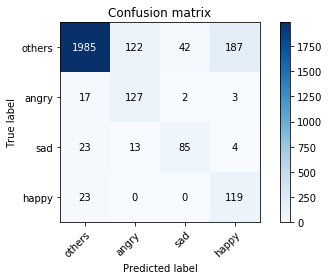

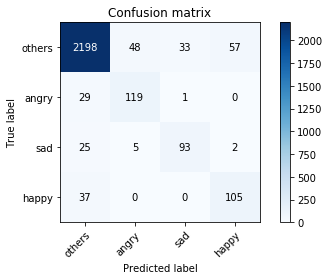

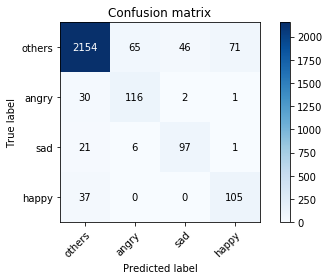

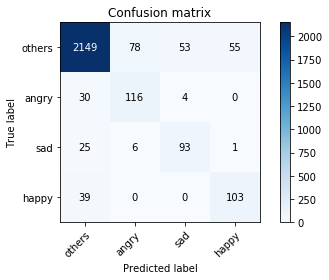

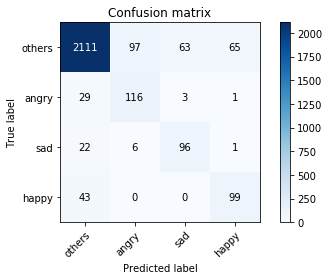

In [14]:
'''=================================  RUN THE TRAINING / TESTING  ================================='''

network= RNNLM(vocab.size(),wordvocab.size(),_hyperparameters_dict['embedding_size'], _hyperparameters_dict['rnn_size'], _hyperparameters_dict['output_size'])
network = network.to(device)

epochs = _hyperparameters_dict['num_epochs']
verbose = 100


optimizer = torch.optim.Adam(network.parameters(),lr=_hyperparameters_dict['learning_rate'])

print(label_dict.getlabellist())
for epoch in range(1, epochs):
    trainRNNM(network,device,data_loader_train,optimizer,epoch, verbose)
    testRNNM(network, device, data_loader_test, verbose)
  

In [0]:
for batch_idx,(data,target) in enumerate(data_loader_train):
  print(data)

In [0]:
for batch_idx,(data,target) in enumerate(data_loader_test):
  print(data)